##Imports and Data Loading

In [ ]:
!cp "./drive/MyDrive/test task/aclImdb_v1.tar.gz" ./dataset.tar.gz

In [ ]:
!tar -xf dataset.tar.gz

In [ ]:
!pip install datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install accelerate -U

In [ ]:
from datasets import Dataset
import glob
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader

In [ ]:
BASE_MODEL = "lvwerra/distilbert-imdb"

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1, ignore_mismatched_sizes=True)

##Preprocessing

In [ ]:
def preprocess(data_path):
  data_neg_paths = glob.glob(os.path.join(data_path,'neg/*'))
  data_pos_paths = glob.glob(os.path.join(data_path,'pos/*'))

  paths = data_neg_paths + data_pos_paths

  data = []

  for path in paths:
    rating = int(path.split('/')[-1].split('_')[-1][:-4])

    with open(path,'r') as inp:
      text = inp.read()

    tokens = tokenizer(text, truncation=True, padding="max_length", max_length=512)
    data.append({"input_ids":tokens['input_ids'],"attention_mask":tokens['attention_mask'],"label":rating/10})

  return Dataset.from_list(data)

In [ ]:
dataTest = preprocess("./aclImdb/test")

In [ ]:
data = preprocess("./aclImdb/train")

In [ ]:
data = data.train_test_split(0.1,seed=42)
dataValid = data['test']
dataTrain = data['train']

In [ ]:
dataTest

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 25000
})

In [ ]:
dataTrain

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 22500
})

In [ ]:
dataValid

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 2500
})

##Train the Model

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)

    return {"rmse": rmse, "mae": mae, "r2": r2}

In [ ]:
from transformers import TrainingArguments, Trainer

LEARNING_RATE = 2e-5
BATCH_SIZE = 16
EPOCHS = 5

training_args = TrainingArguments(
    output_dir="./models/distilbert-review-rating",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="rmse",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [ ]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=dataTrain,
    eval_dataset=dataValid,
    compute_metrics=compute_metrics_for_regression,
)

In [ ]:
for name, para in model.named_parameters():
  print(name)

distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_norm.bias
distil

In [ ]:
parameters_to_tune = [name for name, para in model.named_parameters()][-6:]

In [ ]:
parameters_to_tune

['distilbert.transformer.layer.5.output_layer_norm.weight',
 'distilbert.transformer.layer.5.output_layer_norm.bias',
 'pre_classifier.weight',
 'pre_classifier.bias',
 'classifier.weight',
 'classifier.bias']

In [ ]:
for name, para in model.named_parameters():
  if name not in parameters_to_tune:
    para.requires_grad = False
  else:
    para.requires_grad = True
    print(name)

distilbert.transformer.layer.5.output_layer_norm.weight
distilbert.transformer.layer.5.output_layer_norm.bias
pre_classifier.weight
pre_classifier.bias
classifier.weight
classifier.bias


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rmse,Mae,R2
1,0.027100,0.019469,0.139531,0.100945,0.835081
2,0.022300,0.019139,0.138343,0.101930,0.837877
3,0.021000,0.019069,0.138089,0.099034,0.838472
4,0.020900,0.019351,0.139106,0.098985,0.836084
5,0.021100,0.019095,0.138185,0.098708,0.838247


TrainOutput(global_step=7035, training_loss=0.023474483017219917, metrics={'train_runtime': 2254.0432, 'train_samples_per_second': 49.91, 'train_steps_per_second': 3.121, 'total_flos': 1.49023165824e+16, 'train_loss': 0.023474483017219917, 'epoch': 5.0})

#Evaluate model

In [ ]:
!cp "/content/drive/MyDrive/test task/distilbert-review-rating" ./ -R

In [ ]:
model_path = './distilbert-review-rating/checkpoint-7035'
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=1)

trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=dataTrain,
    eval_dataset=dataValid,
    compute_metrics=compute_metrics_for_regression,
)

In [ ]:
trainer.eval_dataset=dataTest
trainer.evaluate()

{'eval_loss': 0.027737870812416077,
 'eval_rmse': 0.16654689610004425,
 'eval_mae': 0.11524546891450882,
 'eval_r2': 0.7723775362790705,
 'eval_runtime': 432.3623,
 'eval_samples_per_second': 57.822,
 'eval_steps_per_second': 3.615,
 'epoch': 5.0}

##Scoring the model

In [ ]:
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
preds = trainer.predict(dataTest)

In [ ]:
preds

PredictionOutput(predictions=array([[0.3471922 ],
       [0.08967724],
       [0.3750235 ],
       ...,
       [1.0106809 ],
       [0.5419685 ],
       [0.9782608 ]], dtype=float32), label_ids=array([0.3, 0.1, 0.3, ..., 1. , 0.7, 0.9], dtype=float32), metrics={'test_loss': 0.027350058779120445, 'test_rmse': 0.16537852585315704, 'test_mae': 0.11325232684612274, 'test_r2': 0.7755600210909444, 'test_runtime': 443.5843, 'test_samples_per_second': 56.359, 'test_steps_per_second': 3.524})

In [ ]:
test_preds = preds[0]
test_preds[test_preds<0.1] = 0.1
test_preds[test_preds>1] = 1

test_ratings = preds[1]

In [ ]:
test_r2 = r2_score(test_ratings,test_preds)

In [ ]:
test_rmse = mean_squared_error(test_ratings,test_preds, squared=False)

In [ ]:
print(f"R2: test = {round(test_r2,3)}")
print("RMSE: test=",round(test_rmse,3))

R2: test = 0.776
RMSE: test= 0.165


Regressor: ROC AUC=0.944


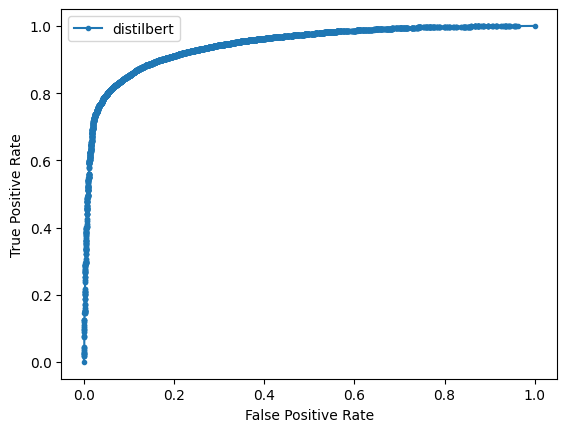

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, f1_score, classification_report


test_labels = [1 if l > 0.4 else 0 for l in test_ratings]

auc = roc_auc_score(test_labels, test_preds)

# summarize scores
print('Regressor: ROC AUC=%.3f' % (auc))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label='distilbert')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [ ]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_thresh = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_thresh, gmeans[ix]))

Best Threshold=0.384609, G-Mean=0.876


In [ ]:
test_preds_labels = np.array([1 if s >best_thresh else 0 for s in test_preds])

In [ ]:
print(classification_report(test_labels, test_preds_labels))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      9865
           1       0.93      0.84      0.89     15135

    accuracy                           0.87     25000
   macro avg       0.86      0.88      0.87     25000
weighted avg       0.88      0.87      0.87     25000



In [ ]:
test_preds_ratings = test_preds*10
test_true_ratings = (test_ratings*10).astype(np.int8)

In [ ]:
preds_by_rating = {}

for r,p in zip(test_true_ratings,test_preds_ratings):
  if r not in preds_by_rating:
    preds_by_rating[r] = []

  preds_by_rating[r].append(p)

rating: 1, preds mean: 2.0920000076293945, std: 1.305999994277954
rating: 2, preds mean: 2.5350000858306885, std: 1.3519999980926514
rating: 3, preds mean: 3.0250000953674316, std: 1.534000039100647
rating: 4, preds mean: 3.6670000553131104, std: 1.878000020980835
rating: 7, preds mean: 7.558000087738037, std: 1.7259999513626099
rating: 8, preds mean: 8.222000122070312, std: 1.4329999685287476
rating: 9, preds mean: 8.586999893188477, std: 1.2300000190734863
rating: 10, preds mean: 8.831000328063965, std: 1.3359999656677246


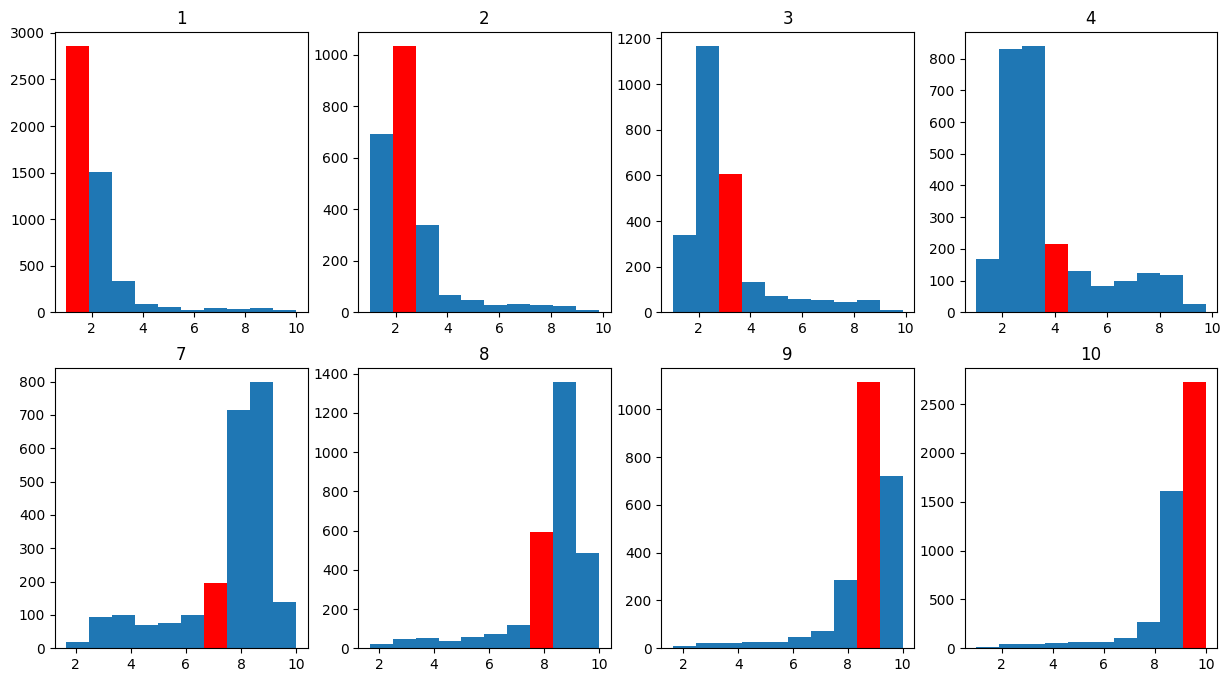

In [ ]:
f, axs = plt.subplots(2, 4, figsize=(15, 8))

for id,rating in enumerate(sorted(preds_by_rating.keys())):
  preds = np.array(preds_by_rating[rating])
  print(f"rating: {rating}, preds mean: {round(preds.mean(),3)}, std: {round(preds.std(),3)}")
  plt.subplot(2,4,id+1)
  n, bins, patches = plt.hist(preds)
  patches[rating-1].set_fc('r')
  plt.title(rating)
plt.show()